# **Градиентный бустинг**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Код для получения пути к файлам в Kaggle

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [ ]:
%pip install numpy==1.26.4 pandas==2.1.4 scikit-learn==1.7.0 matplotlib==3.8.0 seaborn==0.13.2 catboost==1.2.8 lightgbm==4.6.0 xgboost==3.0.2 optuna==4.4.0

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [2]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'matplotlib': '3.8.0',
    'seaborn': '0.13.2',
    'catboost': '1.2.8',
    'lightgbm': '4.6.0',
    'xgboost': '3.0.2',
    'optuna': '4.4.0'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status:<12}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.11.9       | ✓           
numpy           | 1.26.4       | 1.26.4       | ✓           
pandas          | 2.1.4        | 2.1.4        | ✓           
scikit-learn    | 1.7.0        | 1.7.0        | ✓           
matplotlib      | 3.8.0        | 3.8.0        | ✓           
seaborn         | 0.13.2       | 0.13.2       | ✓           
catboost        | 1.2.8        | 1.2.8        | ✓           
lightgbm        | 4.6.0        | 4.6.0        | ✓           
xgboost         | 3.0.2        | 3.0.2        | ✓           
optuna          | 4.4.0        | 4.4.0        | ✓           

Результат проверки:  ✓
Все версии соответствуют требованиям


## **Импорт библиотек и вспомогательные функции**

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.importance import get_param_importances
from optuna.samplers import TPESampler

In [5]:
RANDOM_STATE = 42

## **Практическая часть**

### **Градиентный бустинг**

Градиентный бустинг (Gradient Boosting) — это метод машинного обучения, основанный на ансамбле слабых моделей, которые последовательно улучшают предсказания друг друга. В отличие от случайного леса, где деревья строятся независимо, в градиентном бустинге над решающими деревьями каждое новое дерево обучается на ошибках предыдущих.

**Алгоритм обучения:**

1. Инициализируется начальное предсказание $f_{0}(X)$, где $X$ — матрица признаков. Например:

    * Метка наиболее популярного класса (для задач классификации).

    * Среднее значение или ноль (для задач регрессии).

2. Для каждой итерации обучения $t=1,...,T$:

    1. Вычисляются остатки (градиент ошибки): $r_{t}=y-f_{t-1}(X)$, где $y$ — истинные значения целевой переменной.

    2. Обучается дерево решений $h_{t}(X)$​ для предсказания остатков $r_{t}$.

    3. Модель обновляется: $f_{t}(X)=f_{t-1}(X)+\gamma h_{t}(X)$, где $\gamma$ — темп (шаг) обучения.

Подробнее можно изучить по **ссылкам:**

* [Градиентный бустинг | education.yandex.ru](https://education.yandex.ru/handbook/ml/article/gradientnyj-busting)

* [All You Need to Know about Gradient Boosting Algorithm − Part 1. Regression | medium.com](https://medium.com/data-science/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502)

* [All You Need to Know about Gradient Boosting Algorithm − Part 2. Classification | towardsdatascience.com](https://medium.com/p/d3ed8f56541e)

### ***Задание 1***

Сгенерируйте простой набор данных для регрессии с одной объясняющей переменной (см. код):

* `y_true` — истинные значения целевой переменной.

* `y` — "зашумленные" значения целевой переменной.

На сгенерированной выборке обучите 10 деревьев решений DecisionTreeRegressor со значениями параметра **max_depth от 1 до 10**. 

Для каждого обученного дерева рассчитайте MSE на `y` и `y_true`, постройте график предсказаний.

Дополните класс CustomGradientBoostingRegressor, добавив недостающий код там, где это необходимо (**в качестве начального значения используйте среднее**).

Обучите модель `gb_reg_def` (CustomGradientBoostingRegressor) **c параметрами по умолчанию**: n_estimators=100, learning_rate=0.1, max_depth=1.

Выполните подбор оптимальных гиперпараметров для кастомного класса CustomGradientBoostingRegressor с помощью GridSearchCV (см. замечание ниже).

Обучите модель `gb_reg` (CustomGradientBoostingRegressor) с оптимальными гиперпараметрами на полной выборке.

Сравните результаты обучения деревьев с разной глубиной (DecisionTreeRegressor) и моделей `gb_reg_def` и `gb_reg`, рассчитав MSE на `y` и `y_true`, а также построив графики предсказаний для каждой из моделей.

*Класс CustomGradientBoostingRegressor **наследует от класса BaseEstimator**. Класс BaseEstimator в sklearn является базовым классом, предоставляющим встроенные реализации ключевых методов для оптимизации, кросс-валидации и автоматического конфигурирования моделей в рамках библиотеки sklearn. Это позволяет, например, выполнять оптимизацию гипермараметров моделей кастомного (пользовательского) класса CustomGradientBoostingRegressor с помощью GridSearchCV, если в кастомном классе присутствует реализация методов fit, predict и scoring.*

In [66]:
# Сгенерируйте простой набор данных для регрессии

rng = np.random.RandomState(RANDOM_STATE)
noise = rng.normal(0, 0.18, 1000)
X = pd.DataFrame({'x': np.linspace(1, 10, 1000)})
y_true = -0.3 * X['x'] ** 0.5 * np.cos(np.pi * X['x'] / 4)
y_true = np.array(y_true)
y = y_true + noise

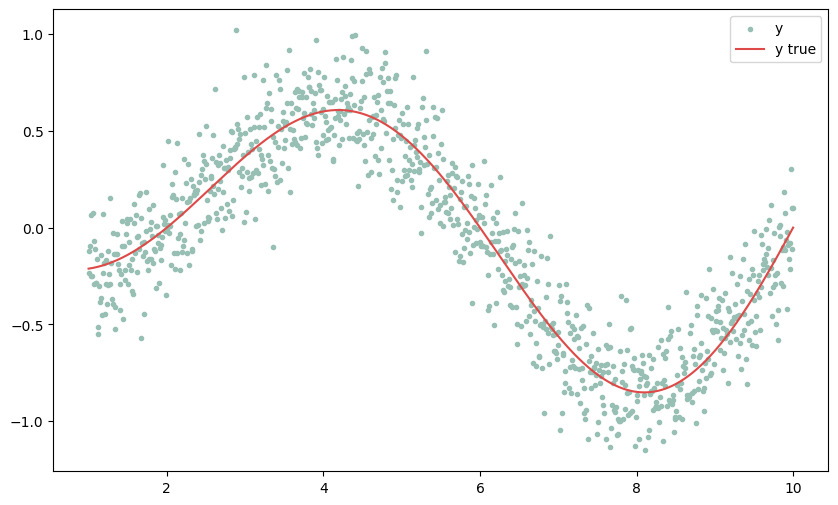

In [67]:
# Постройте график y и y_true

plt.figure(figsize=(10,6))
plt.scatter(X['x'], y, marker='.', c='#97BFB4', label='y')
plt.plot(X['x'], y_true, c='#DD4A48', label='y true')
plt.legend()
plt.show()

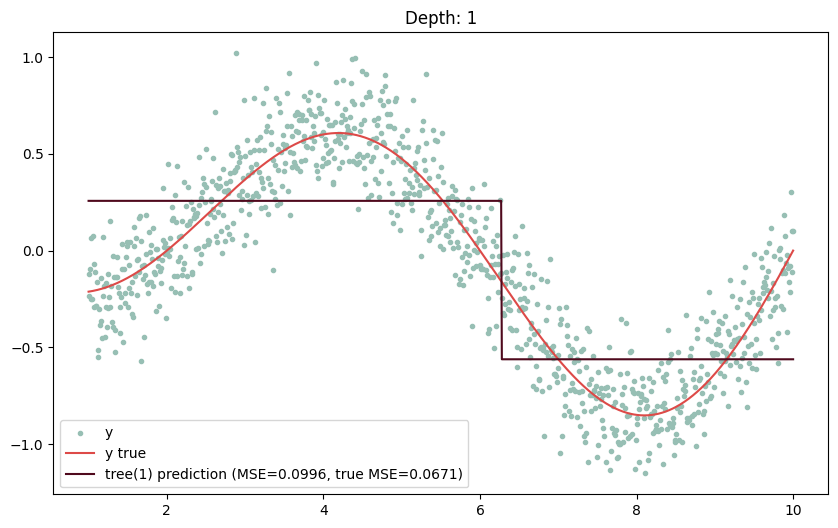

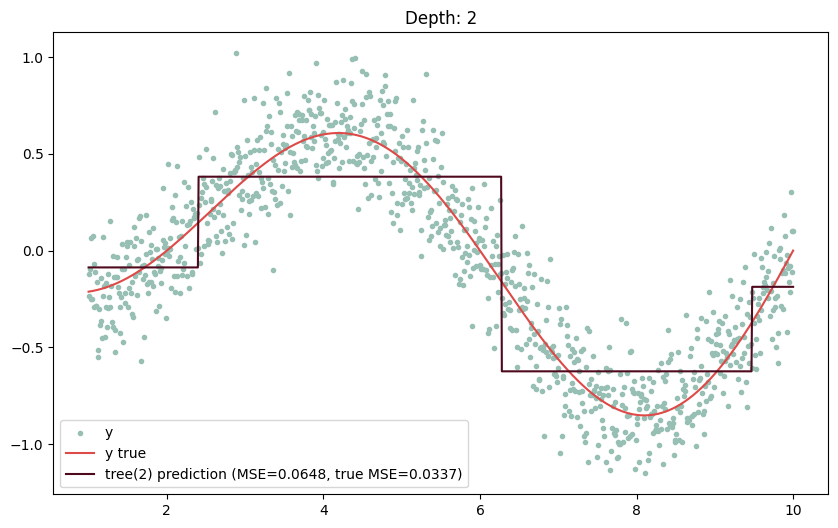

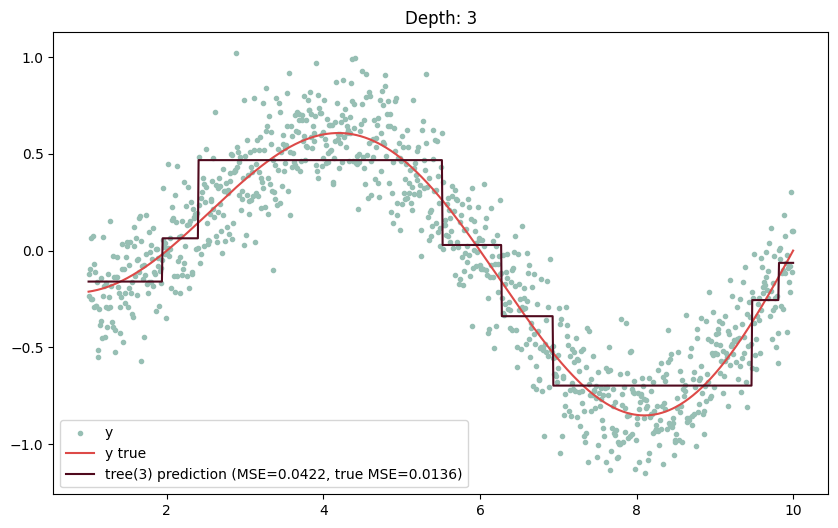

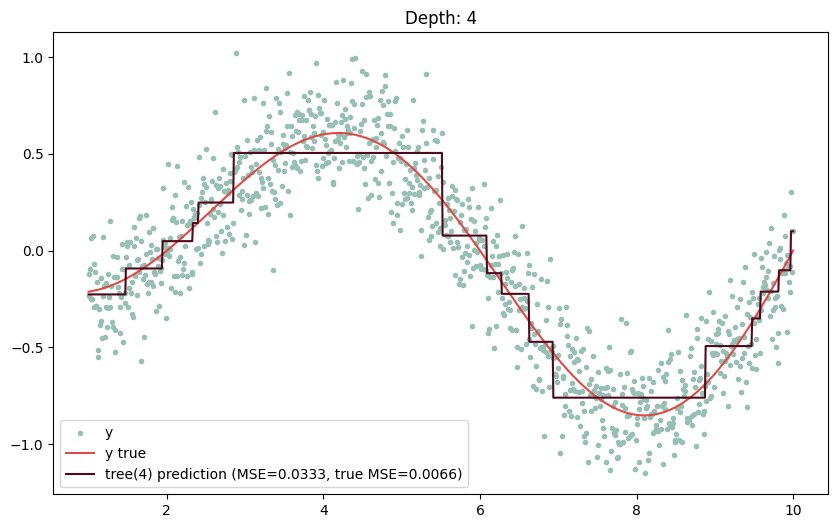

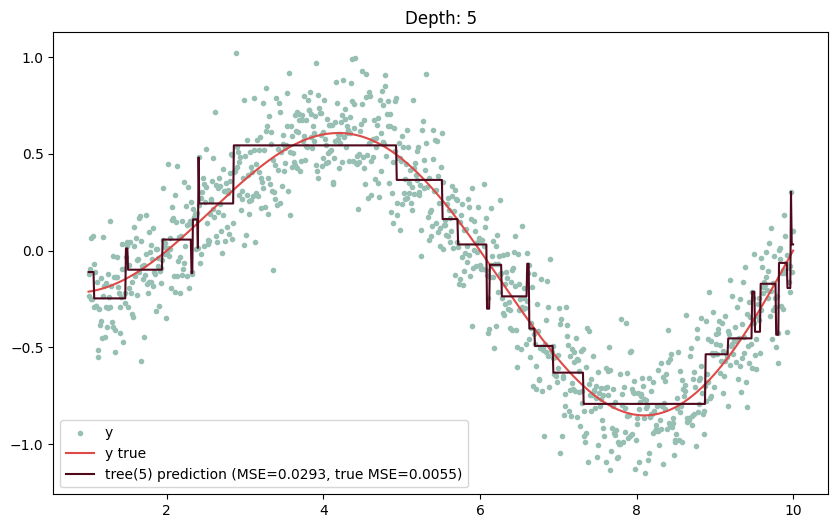

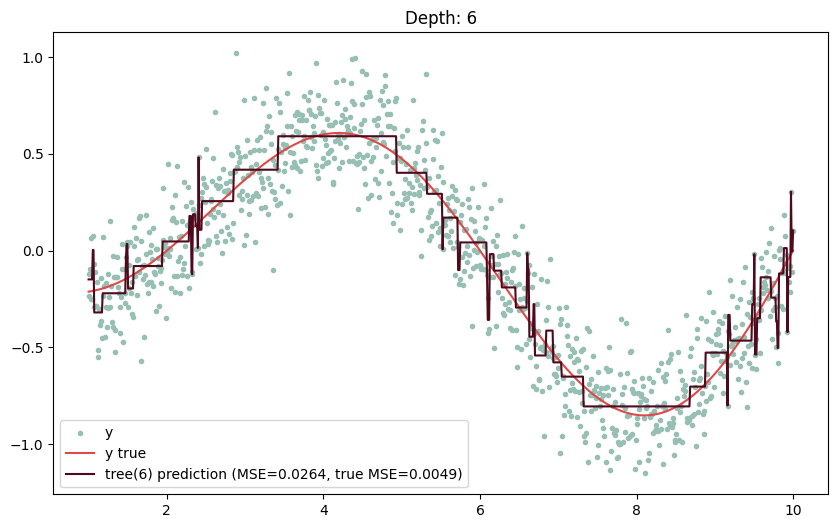

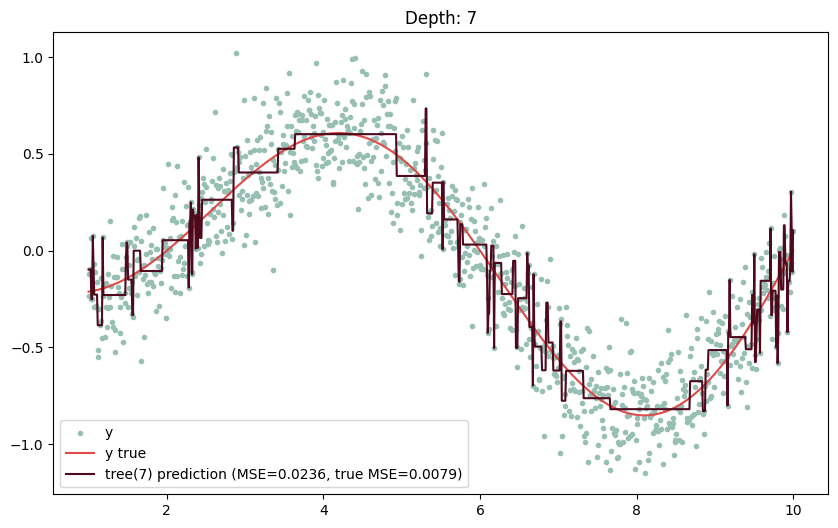

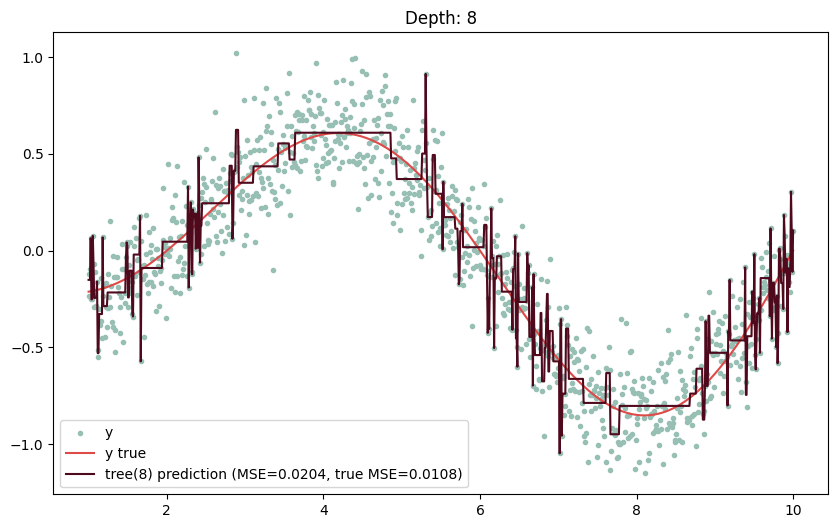

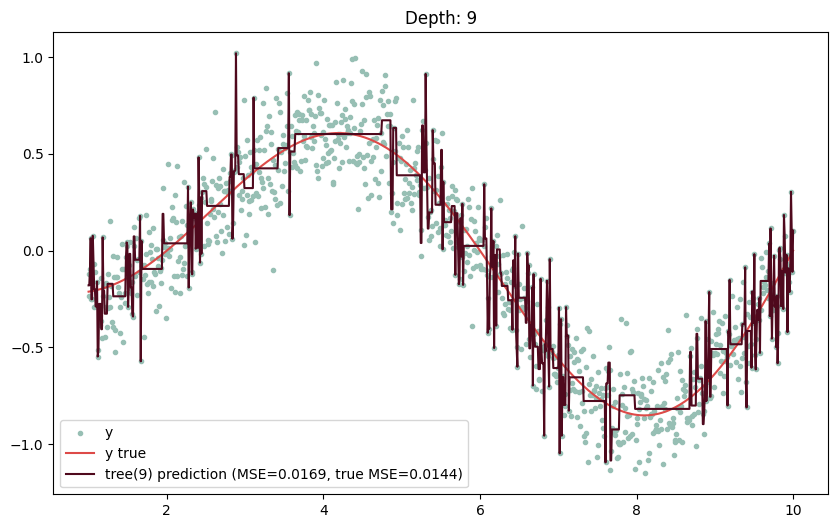

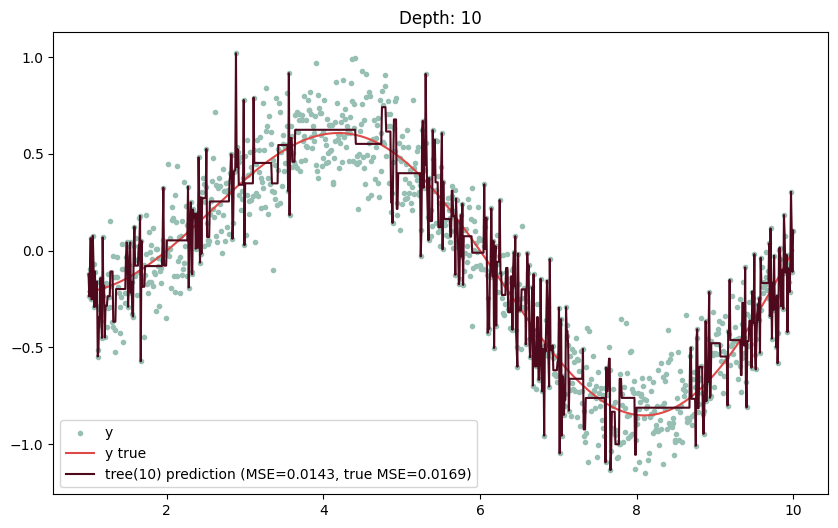

In [68]:
# Обучите 10 деревьев DecisionTreeRegressor со значениями параметра max_depth от 1 до 10
# Для каждого дерева рассчитайте MSE на y и y_true, постройте график предсказаний
# Не забудьте зафиксировать RANDOM_STATE

for i in range(1, 11):
    tree_reg_i = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=i).fit(X, y)
    y_pred_tree_reg_i = tree_reg_i.predict(X)
    mse = mean_squared_error(y, y_pred_tree_reg_i)
    mse_true = mean_squared_error(y_true, y_pred_tree_reg_i)
    plt.figure(figsize=(10,6))
    plt.title(f'Depth: {i}')
    plt.scatter(X['x'], y, marker='.', c='#97BFB4', label='y')
    plt.plot(X['x'], y_true, c='#DD4A48', label='y true')
    plt.plot(X['x'], y_pred_tree_reg_i, c='#4F091D',
             label=f'tree({i}) prediction (MSE={mse:.4f}, true MSE={mse_true:.4f})')
    plt.legend()
    plt.show()

In [81]:
# Дополните класс CustomGradientBoostingRegressor
# Код метода score изменять не нужно
# Не забудьте фиксировать random_state, где это возможно

class CustomGradientBoostingRegressor(BaseEstimator):
    """
    Простой регрессор на основе градиентного бустинга над деревьями решений.

    Аргументы:
        n_estimators (int): Количество деревьев (итераций бустинга). По умолчанию — 100.
        learning_rate (float) Темп обучения (шаг градиентного спуска). По умолчанию — 0.1.
        max_depth (int): Максимальная глубина дерева бустинга. По умолчанию — 1.
        random_state : (int|None): Сид для фиксирования случайного состояния. По умолчанию — None (не фиксировать).

    Атрибуты:
        f0 (float): Начальное предсказание (среднее значение целевой переменной).
        models (list[DecisionTreeRegressor]): Последовательность деревьев, составляющих модель градиентного бустинга.
    """
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.f0 = None
        self.models = []

    def fit(self, X, y):
        """
        Обучает модель градиентного бустинга.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив значений целевой переменной.

        Возвращает: 
            CustomGradientBoostingRegressor: Обученная модель градиентного бустинга.
        """
        self.f0 = np.mean(y)
        y_pred = np.full_like(y, self.f0)
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeRegressor(random_state=self.random_state, max_depth=self.max_depth).fit(X, residuals)
            y_pred += self.learning_rate * tree.predict(X)
            self.models.append(tree)
        return self

    def predict(self, X):
        """
        Предсказывает значения целевой переменной.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.

        Возвращает:
            numpy.ndarray: Массив предсказанных значений целевой переменной.
        """
        y_pred = np.full(X.shape[0], self.f0)
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        return y_pred
    
    def score(self, X, y):
        """
        Вычисляет отрицательное значение MSE (Negative MSE) для прогноза.
        Метод необходим для применения GridSearchCV.

        Аргументы:
            X (pandas.DataFrame): Таблица с признаками.
            y (numpy.ndarray): Массив значений целевой переменной.

        Возвращает:
            float: Значение Negative MSE.
        """
        return -mean_squared_error(y, self.predict(X))

In [59]:
# Обучите модель gb_reg_def (CustomBoostRegressor c параметрами по умолчанию)
# Не забудьте зафиксировать RANDOM_STATE

gb_reg_def = CustomGradientBoostingRegressor(random_state=RANDOM_STATE).fit(X, y)

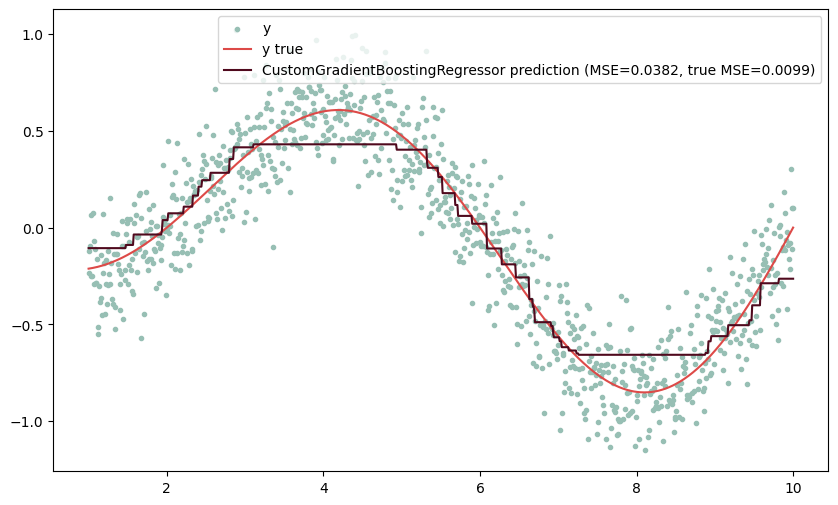

In [71]:
# Для модели gb_reg_def посчитайте MSE на y и y_true, постройте график предсказаний

y_pred_gb_reg_def = gb_reg_def.predict(X)
mse_gb_reg_def = mean_squared_error(y, y_pred_gb_reg_def)
mse_true_gb_reg_def = mean_squared_error(y_true, y_pred_gb_reg_def)

plt.figure(figsize=(10,6))
plt.scatter(X['x'], y, marker='.', c='#97BFB4', label='y')
plt.plot(X['x'], y_true, c='#DD4A48', label='y true')
plt.plot(X['x'], y_pred_gb_reg_def, c='#4F091D', 
         label=f'CustomGradientBoostingRegressor prediction (MSE={mse_gb_reg_def:.4f}, true MSE={mse_true_gb_reg_def:.4f})')
plt.legend()
plt.show()

In [82]:
# Подберите оптимальные гиперпараметры для кастомного класса CustomGradientBoostingRegressor с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'max_depth': [1, 2, 3]
}
cv = 5

cv_gb_reg = GridSearchCV(
    estimator=CustomGradientBoostingRegressor(random_state=RANDOM_STATE)
    , cv=cv
    , param_grid=params
    , n_jobs=-1
).fit(X, y)

In [83]:
# Выведите оптимальные гиперпараметры по результатам оптимизации

cv_gb_reg.best_params_

{'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 150}

In [84]:
# Обучите модель gb_reg (CustomBoostRegressor) с оптимальными гиперпараметрами
# Не забудьте зафиксировать RANDOM_STATE

gb_reg = cv_gb_reg.best_estimator_.fit(X, y)

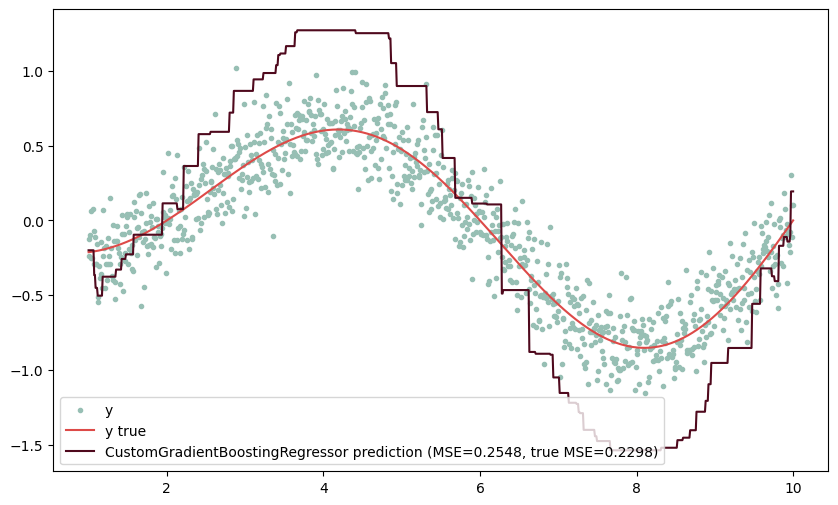

In [85]:
# Для модели gb_reg посчитайте MSE на y и y_true, постройте график предсказаний

y_pred_gb_reg = gb_reg.predict(X)
mse_gb_reg = mean_squared_error(y, y_pred_gb_reg)
mse_true_gb_reg = mean_squared_error(y_true, y_pred_gb_reg)

plt.figure(figsize=(10,6))
plt.scatter(X['x'], y, marker='.', c='#97BFB4', label='y')
plt.plot(X['x'], y_true, c='#DD4A48', label='y true')
plt.plot(X['x'], y_pred_gb_reg, c='#4F091D', 
         label=f'CustomGradientBoostingRegressor prediction (MSE={mse_gb_reg:.4f}, true MSE={mse_true_gb_reg:.4f})')
plt.legend()
plt.show()

### **XGBoost, LightGBM и CatBoost**

Среди существующих реализаций градиентного бустинга выделяются три наиболее эффективных и популярных алгоритма: XGBoost, LightGBM и CatBoost.

* Extreme Gradient Boosting ([XGBoost](https://xgboost.readthedocs.io/en/latest/), DMLC 2014 г.) — эффективный и гибкий алгоритм градиентного бустинга с поддержкой регуляризации и параллельного обучения, обеспечивающий высокую производительность и универсальность. Алгоритм требует предварительной обработки категориальных признаков (например, One-Hot кодирование).

* Light Gradient-Boosting Machine ([LightGBM](https://lightgbm.readthedocs.io/en/latest/), Microsoft 2016 г.) — алгоритм, который выделяется высокой скоростью обучения и масштабируемостью для больших объёмов данных и многомерных признаков. Алгоритм требует предварительной обработки категориальных признаков.


* Category Boosting ([CatBoost](https://catboost.ai/), Яндекс 2017 г.) — алгоритм, который специализируется на эффективной работе с категориальными признаками и обладает устойчивостью к переобучению благодаря симметричной структуре деревьев. Алгоритм не требует предварительной обработки категориальных признаков — реализована автоматическая обработка категориальных признаков.

Подробнее про эти алгоритмы можно почитать по **ссылкам**: 

* [XGBoost, LightGBM или CatBoost - какой алгоритм бустинга следует использовать? | vk.com](https://vk.com/@coeusds-xgboost-lightgbm-ili-catboost-kakoi-algoritm-bustinga-sled)

### **Датасет *Employee dataset***

**Для решения задания 2 рассмотрим датасет [Employee dataset](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset).**

Набор данных предназначен для анализа факторов, влияющих на увольнение сотрудников.

Целевая переменная — LeaveOrNot:

* 1 — сотрудник уволился.

* 0 — сотрудник продолжает работать.

Датасет включает в себя признаки:

* Education — уровень образования.

* JoiningYear — год принятия на работу.

* City — город, в котором расположен офис сотрудника.

* PaymentTier — уровень заработной платы (категория).

* Age — возраст.

* Gender — пол.

* EverBenched — был ли сотрудник когда-либо "на скамейке запасных" (не задействован в проектах компании).

* ExperienceInCurrentDomain — опыт работы в текущей должности (в годах).

### ***Задание 2***

Выполните предобработку датасета (см. код) и убедитесь, что по результатам предобработки:

* Датасет разделён на обучающую и тестовую выборки со стратификацией по целевой переменной в соотношении: **train — 75%, test — 25%**.

* Имеются два набора датасетов с признаками:

    * `X_empl_train`, `X_empl_test` — датасеты **без применения One-Hot кодирования**. Используйте для обучения и оценки **модели `catb_empl` (CatBoostClassifier)**.

    * `X_empl_train_onehot`, `X_empl_test_onehot` — датасеты **с применением One-Hot кодирования**. Используйте для обучения и оценки **всех моделей, кроме `catb_empl`**.

С помощью **RandomizedSearchCV** (n_iter=50) выполните поиск оптимальных гиперпараметров (для каждой из модели в одельности), и на оптимальном наборе параметров обучите модели:

* `rf_empl` — случайный лес (RandomForestClassifier). Подбор параметров и обучение на `X_empl_train_onehot`.

* `gb_empl` — градиентный бустинг sklearn (GradientBoostingClassifier). Подбор параметров и обучение на `X_empl_train_onehot`.

* `xgb_empl` — модель XGBoost (XGBClassifier). Подбор параметров и обучение на `X_empl_train_onehot`.

* `lgbm_empl` — модель LightGBM (LGBMClassifier). Подбор параметров и обучение на `X_empl_train_onehot`.

* `catb_empl` — модель CatBoost (CatBoostClassifier). **Подбор параметров и обучение на `X_empl_train`**.

Сравните качество прогноза моделей, рассчитав метрики AUC и f1 на тестовых выборках (`X_empl_test` и `X_empl_test_onehot`).

*На практике количество итераций при оптимизации гиперпараметров с помощью RandomizedSearchCV зависит от сложности модели и размера датасета. Для реальных задач 50 итераций, вероятнее всего, будет недостаточно. В рамках данного задания небольшое число итераций используется для экономии времени.*

In [129]:
# Считайте набор данных

df_empl = pd.read_csv('employee.csv')
df_empl

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [130]:
# Информация о типах столбцов в датасете

df_empl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [131]:
# Количество уникальных значений в каждом из столбцов датасета 

df_empl.nunique()

Education                     3
JoiningYear                   7
City                          3
PaymentTier                   3
Age                          20
Gender                        2
EverBenched                   2
ExperienceInCurrentDomain     8
LeaveOrNot                    2
dtype: int64

In [132]:
# Создайте список категориальных переменных (не включая целевую переменную)

empl_cat_feat = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']

In [133]:
# Выделите объясняемый фактор в отдельную переменную

X_empl, y_empl = df_empl.drop(columns=['LeaveOrNot']), df_empl['LeaveOrNot']

In [134]:
# Разделите датасет на обучающую (75%) и тестовую (25%) выборки со стратификацией по целевой переменной
# Напоминание: не забудьте про RANDOM_STATE

X_empl_train, X_empl_test, y_empl_train, y_empl_test = train_test_split(X_empl, y_empl,
                                                                        test_size=0.25,
                                                                        stratify=y_empl,
                                                                        random_state=RANDOM_STATE)

In [135]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder
# Выделите отдельные датасеты с закодированными признаками
#   train -> fit_transform
#   test -> transform

empl_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_empl_train_onehot = empl_encoder.fit_transform(X_empl_train[empl_cat_feat])
X_empl_test_onehot = empl_encoder.transform(X_empl_test[empl_cat_feat])

# Объединяем числовые и закодированные признаки
X_empl_train_onehot = X_empl_train.drop(columns=empl_cat_feat).join(X_empl_train_onehot)
X_empl_test_onehot = X_empl_test.drop(columns=empl_cat_feat).join(X_empl_test_onehot)

In [136]:
# Сформируем таблицу для сравнения качества прогноза моделей на тестовой выборке

empl_results = pd.DataFrame({
    'model': ['rf_empl', 'gb_empl', 'xgb_empl', 'lgbm_empl', 'catb_empl'],
    'auc_roc': np.zeros(5),
    'f1': np.zeros(5)
})
empl_results = empl_results.set_index('model', drop=True)

##### `rf_empl` (RandomForestClassifier)

In [137]:
# Подберите оптимальные гиперпараметры обучения rf_empl с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

estimator = RandomForestClassifier(random_state=RANDOM_STATE)
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(50, 300)
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

rf_empl = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1, # Может ускорить вычисления за счёт параллелизма, не влияет на результат
    refit=True # Переобучает модель на всей выборке после подбора гиперпараметров (по умолчанию True, можно не указывать)
).fit(X_empl_train_onehot, y_empl_train)

In [138]:
# Результат подбора гиперпараметров для rf_empl

print(f'Итерация: {rf_empl.best_index_}')
print(f'AUC: {rf_empl.best_score_:.4f}')
print(f'Параметры: {rf_empl.best_params_}')

Итерация: 38
AUC: 0.8745
Параметры: {'n_estimators': 292, 'max_depth': 8}


In [139]:
# Средняя продолжительность обучения rf_empl (сек.)

print('{:.4f}'.format(rf_empl.cv_results_['mean_fit_time'].mean()))

0.6286


In [140]:
# На тестовой выборке оцените AUC и f1 для модели rf_empl
# Добавьте результат в empl_results

empl_results.loc['rf_empl', 'auc_roc'] = roc_auc_score(y_empl_test, rf_empl.best_estimator_.predict_proba(X_empl_test_onehot)[:, 1])
empl_results.loc['rf_empl', 'f1'] = f1_score(y_empl_test, rf_empl.best_estimator_.predict(X_empl_test_onehot))

##### `gb_empl` (GradientBoostingClassifier)

In [141]:
# Подберите оптимальные гиперпараметры обучения gb_empl с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

estimator = GradientBoostingClassifier(random_state=RANDOM_STATE)
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(50, 300),
    'learning_rate': np.linspace(0.05, 0.95, 100)
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

gb_empl = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE
).fit(X_empl_train_onehot, y_empl_train)

In [142]:
# Результат подбора гиперпараметров для gb_empl

print(f'Итерация: {gb_empl.best_index_}')
print(f'AUC: {gb_empl.best_score_:.4f}')
print(f'Параметры: {gb_empl.best_params_}')

Итерация: 16
AUC: 0.8709
Параметры: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.10454545454545455}


In [143]:
# Средняя продолжительность обучения gb_empl (сек.)

print('{:.4f}'.format(gb_empl.cv_results_['mean_fit_time'].mean()))

2.6547


In [144]:
# На тестовой выборке оцените AUC и f1 для модели gb_empl
# Добавьте результат в empl_results

empl_results.loc['gb_empl', 'auc_roc'] = roc_auc_score(y_empl_test, gb_empl.best_estimator_.predict_proba(X_empl_test_onehot)[:, 1])
empl_results.loc['gb_empl', 'f1'] = f1_score(y_empl_test, gb_empl.best_estimator_.predict(X_empl_test_onehot))

##### `xgb_empl` (XGBClassifier)

In [145]:
# Подберите оптимальные гиперпараметры обучения xgb_empl с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

estimator = XGBClassifier(random_state=RANDOM_STATE)
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(50, 300),
    'learning_rate': np.linspace(0.05, 0.95, 100)
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

xgb_empl = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE
).fit(X_empl_train_onehot, y_empl_train)

In [146]:
# Результат подбора гиперпараметров для xgb_empl

print(f'Итерация: {xgb_empl.best_index_}')
print(f'AUC: {xgb_empl.best_score_:.4f}')
print(f'Параметры: {xgb_empl.best_params_}')

Итерация: 16
AUC: 0.8740
Параметры: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.10454545454545455}


In [147]:
# Средняя продолжительность обучения xgb_empl (сек.)

print('{:.4f}'.format(xgb_empl.cv_results_['mean_fit_time'].mean()))

0.1763


In [148]:
# На тестовой выборке оцените AUC и f1 для модели xgb_empl
# Добавьте результат в empl_results

empl_results.loc['xgb_empl', 'auc_roc'] = roc_auc_score(y_empl_test, xgb_empl.best_estimator_.predict_proba(X_empl_test_onehot)[:, 1])
empl_results.loc['xgb_empl', 'f1'] = f1_score(y_empl_test, xgb_empl.best_estimator_.predict(X_empl_test_onehot))

##### `lgbm_empl` (LGBMClassifier)

In [149]:
# Подберите оптимальные гиперпараметры обучения lgbm_empl с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

estimator = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1) # verbose=-1
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(50, 300),
    'learning_rate': np.linspace(0.05, 0.95, 100)
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

lgbm_empl = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE
).fit(X_empl_train_onehot, y_empl_train)

In [150]:
# Результат подбора гиперпараметров для lgbm_empl

print(f'Итерация: {lgbm_empl.best_index_}')
print(f'AUC: {lgbm_empl.best_score_:.4f}')
print(f'Параметры: {lgbm_empl.best_params_}')

Итерация: 16
AUC: 0.8731
Параметры: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.10454545454545455}


In [151]:
# Средняя продолжительность обучения lgbm_empl (сек.)

print('{:.4f}'.format(lgbm_empl.cv_results_['mean_fit_time'].mean()))

0.7111


In [152]:
# На тестовой выборке оцените AUC и f1 для модели lgbm_empl
# Добавьте результат в empl_results

empl_results.loc['lgbm_empl', 'auc_roc'] = roc_auc_score(y_empl_test, lgbm_empl.best_estimator_.predict_proba(X_empl_test_onehot)[:, 1])
empl_results.loc['lgbm_empl', 'f1'] = f1_score(y_empl_test, lgbm_empl.best_estimator_.predict(X_empl_test_onehot))

##### `catb_empl` (CatBoostClassifier)

In [124]:
# Подберите оптимальные гиперпараметры обучения catb_empl с помощью RandomizedSearchCV
# Не забудьте зафиксировать RANDOM_STATE

estimator = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, cat_features=empl_cat_feat)
params = {
    'max_depth': range(1, 11),
    'n_estimators': range(50, 300),
    'learning_rate': np.linspace(0.05, 0.95, 100)
}
n_iter = 50
scoring = 'roc_auc'
cv = 5

catb_empl = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=n_iter,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE
).fit(X_empl_train, y_empl_train)

In [125]:
# Результат подбора гиперпараметров для catb_empl

print(f'Итерация: {catb_empl.best_index_}')
print(f'AUC: {catb_empl.best_score_:.4f}')
print(f'Параметры: {catb_empl.best_params_}')

Итерация: 17
AUC: 0.8715
Параметры: {'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.19545454545454544}


In [126]:
# Средняя продолжительность обучения catb_empl (сек.)

print('{:.4f}'.format(catb_empl.cv_results_['mean_fit_time'].mean()))

20.6510


In [157]:
# На тестовой выборке оцените AUC и f1 для модели catb_empl
# Добавьте результат в empl_results

empl_results.loc['catb_empl', 'auc_roc'] = roc_auc_score(y_empl_test, catb_empl.best_estimator_.predict_proba(X_empl_test)[:, 1])
empl_results.loc['catb_empl', 'f1'] = f1_score(y_empl_test, catb_empl.best_estimator_.predict(X_empl_test))

##### Сравнение моделей

In [158]:
# Сравните качество прогноза моделей на тестовых выборках

empl_results

,auc_roc,f1
model,,
rf_empl,0.880250,0.740630
gb_empl,0.883986,0.743106
xgb_empl,0.880234,0.751445
lgbm_empl,0.880190,0.749638
catb_empl,0.879777,0.755682


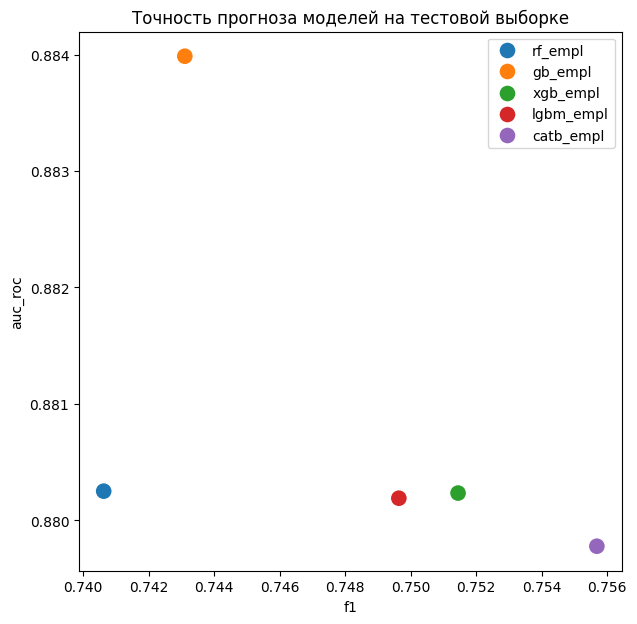

In [159]:
# Визуализируйте качество прогноза моделей, построив график f1 ~ AUC

plt.figure(figsize=(7, 7))
plt.title('Точность прогноза моделей на тестовой выборке')
ax = sns.scatterplot(data=empl_results, x='f1', y='auc_roc', hue='model', s=150)
plt.legend()
plt.show()

### **Early Stopping**

Ранняя остановка (Early Stopping) — это универсальный и широко распространённый метод регуляризации, который позволяет эффективно предотвращать переобучение моделей. Суть метода заключается в остановке обучения модели до завершения всех запланированных итераций в случае, если прогнозные способности модели на валидационной выборке перестают улучшаться или начинают ухудшаться.

**Основные принципы:**

* Исходная выборка делится на подвыборки:

    * Обучающая выборка (train).

    * Валидационная выборка (validation) — на ней оценивается качество модели **во время обучения**.

    * Тестовая выборка (test) — используется для финальной оценки модели (не участвует в процессе обучения).

* Мониторинг метрики. Если в процессе обучения метрика не улучшается в течение заданного числа итераций, обучение останавливается (прекращается).

* Сохранение лучшей модели. Во время обучения сохраняются веса модели на той итерации, когда валидационная метрика была наилучшей.

### **Вероятностные методы оптимизации гиперпараметров**

Вероятностные методы оптимизации гиперпараметров — это итерационные методы, которые позволяют находить оптимальные гиперпараметры обучения моделей быстрее и точнее, чем Grid Search и Randomized Search, за счет использования вероятностной модели целевой функции. 

На каждой итерации метод оценивает, в какой следующей точке с наибольшей вероятностью будет достигнуто улучшение текущей оценки оптимума. Вероятностные методы особенно полезны при работе со сложными многомерными пространствами гиперпараметров.

**Преимущества вероятностных методов перед Grid Search и Randomized Search:**

* Каждая итерация использует информацию, полученную на предыдущих итерациях.

* Вероятностные методы способны моделировать внутренние зависимости между гиперпараметрами.

* Вероятностные методы позволяют достичь более высокого качества, если было выполнено достаточное количество итераций.

* Гибкость. Вероятностные методы способны работать с непрерывными, дискретными и категориальными параметрами.

**Основным недостатком** вероятностных методов является высокая вычислительная сложность по сравнению с Grid Search и Randomized Search.

Одним из основных вероятностных методов является TPE (Tree-structured Parzen Estimator). TPE реализован в двух наиболее популярных библиотеках для оптимизации гиперпараметров: Optuna и Hyperopt.

Подробнее можно изучить по **ссылкам:**

* [Подбор гиперпараметров | education.yandex.ru](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov).

* [Optuna vs Hyperopt: Which Hyperparameter Optimization Library Should You Choose? | eptun.ai](https://neptune.ai/blog/optuna-vs-hyperopt).

### **Датасет *Predict Students' Dropout and Academic Success***

**Для решения задания 3 рассмотрим датасет [Predict Students' Dropout and Academic Success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success).**

**ВНИМАНИЕ:** При решении задания **используйте файл students.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Датасет создан на основе информации из Португальского высшего учебного заведения и содержит информацию о студентах, зачисленных на различные программы бакалавриата: агрономия, дизайн, педагогика и др. Цель датасета — на ранних этапах обучения выявить студентов, находящихся в зоне риска для последующего оказания поддержки. Набор данных включает информацию, известную на момент зачисления студентов (академическая история, демографические и социально-экономические факторы), а также их академическую успеваемость по итогам первого и второго семестров.

Датасет предназначен для решения задачи **многоклассовой классификации**.

Целевая переменная — Target:

* Dropout — студент отчислен.

* Enrolled — студент продолжает обучение.

* Graduate — студент успешно завершил обучение.

Датасет содержит большое количество категориальных признаков, а в целевой переменной присутствует дисбаланс классов.

### ***Задание 3***

Выполните предобработку датасета (см. код).

Обучите модель `catb_stud_def` (CatBoostClassifier) c параметрами `catb_stud_def_params` (для обучения используйте `X_stud_sample_train`).

Обучите модель `catb_stud_es` (CatBoostClassifier) с использованием early stopping ([early_stopping_rounds](https://catboost.ai/docs/en/references/training-parameters/overfitting-detection#early_stopping_rounds) и параметрами `catb_stud_es_params`. Критерий остановки — 50 итераций без увеличения accuracy на валидационной выборке `X_stud_sample_val` (для обучения используйте `X_stud_sample_train`).

Выполните оптимизацию гиперпараметров обучения CatBoostClassifier с помощью optuna. Для этого необходимо определить целевую функцию optuna (objective) **с использованием стратифицированной кросс-валидации ([StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)) и ранней остановки на каждом фолде кросс-валидации** (критерий остановки не фиксируется на одном значении и является оптимизируемым гиперпараметром). Метрика оптимизации гиперпараметров — среднее значение **accuracy** на валидации по результатам кросс-валидации.

На оптимальном наборе признаков и всей обучающей выборке обучите модель `catb_stud` (CatBoostClassifier).

На тестовой выборке постройте отчёт по метрикам классификации для моделей `catb_stud_def`, `catb_stud_es` и `catb_stud`.

*На практике количество итераций при оптимизации гиперпараметров с помощью optuna или hyperopt зависит от сложности модели и размера датасета. **Для реальных задач 50 итераций, вероятнее всего, будет недостаточно**. В рамках данного задания небольшое число итераций используется для экономии времени.*

In [6]:
# Считайте набор данных

df_stud = pd.read_csv('students.csv')
df_stud

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Admission grade,...,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Target
0,1,17,5,171,1,1,1,19,12,127.3,...,0,0.000000,0,0,0,0,0,0.000000,0,Dropout
1,1,15,1,9254,1,1,1,1,3,142.5,...,6,14.000000,0,0,6,6,6,13.666667,0,Graduate
2,1,1,5,9070,1,1,1,37,37,124.8,...,0,0.000000,0,0,6,0,0,0.000000,0,Dropout
3,1,17,2,9773,1,1,1,38,37,119.6,...,6,13.428571,0,0,6,10,5,12.400000,0,Graduate
4,2,39,1,8014,0,1,1,37,38,141.5,...,5,12.333333,0,0,6,6,6,13.000000,0,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,1,1,1,122.2,...,5,13.600000,0,0,6,8,5,12.666667,0,Graduate
4420,1,1,2,9773,1,1,105,1,1,119.0,...,6,12.000000,0,0,6,6,2,11.000000,0,Dropout
4421,1,1,1,9500,1,1,1,37,37,149.5,...,7,14.912500,0,0,8,9,1,13.500000,0,Dropout
4422,1,1,1,9147,1,1,1,37,37,153.8,...,5,13.800000,0,0,5,6,5,12.000000,0,Graduate


In [7]:
# В датасете присутствует дисбаланс классов

df_stud['Target'].value_counts(normalize=True)

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

In [9]:
# Все категориальные признаки описаны числами

df_stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nationality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Admission grade                          

In [10]:
# Количество уникальных значений в каждом из столбцов датасета 

df_stud.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance                          2
Previous qualification                             17
Nationality                                        21
Mother's qualification                             29
Father's qualification                             34
Admission grade                                   620
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder                                  2
Age at enrollment                                  46
International                                       2
Curricular units 1st sem (cr

In [11]:
# Создайте список категориальных переменных (не включая целевую переменную)

stud_cat_feat = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Previous qualification',
                   'Nationality', "Mother's qualification", "Father's qualification", 'Displaced', 'Educational special needs',
                   'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
stud_cat_feat

['Marital status',
 'Application mode',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nationality',
 "Mother's qualification",
 "Father's qualification",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International']

In [14]:
# Выделите объясняемый фактор в отдельную переменную

X_stud, y_stud = df_stud.drop(columns=['Target']), df_stud['Target']

In [17]:
# Разделите датасет на обучающую (50%) и тестовую (50%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_stud_train, X_stud_test, y_stud_train, y_stud_test = train_test_split(X_stud, y_stud,
                                                                        test_size=0.5, stratify=y_stud,
                                                                        random_state=RANDOM_STATE)

In [18]:
# Разделите обучающую выборку (train) на две подвыборки со стратификацией по целевой переменной (по y_stud_train):
#   1. sample_train (75% от train) — для обучения модели
#   2. sample_val (25% от train) — для валидации модели в процессе обучения
# Не забудьте зафиксировать RANDOM_STATE

X_stud_sample_train, X_stud_sample_val, y_stud_sample_train, y_stud_sample_val = train_test_split(X_stud_train,
                                                                                                  y_stud_train,
                                                                                                  stratify=y_stud_train,
                                                                                                  test_size=0.25,
                                                                                                  random_state=RANDOM_STATE)

In [24]:
# Обучите модель catb_stud_def
# Для обучения используйте sample_train, sample_val также укажите для визуализации обучения

catb_stud_def_params = {
    'cat_features': stud_cat_feat,
    'eval_metric': 'Accuracy', # Метрика для оценки качества на валидации (при early stopping)
    'random_state': RANDOM_STATE,
    'verbose': False
}

catb_stud_def = CatBoostClassifier(**catb_stud_def_params).fit(
    X_stud_sample_train, y_stud_sample_train,
    eval_set=(X_stud_sample_val, y_stud_sample_val)
)

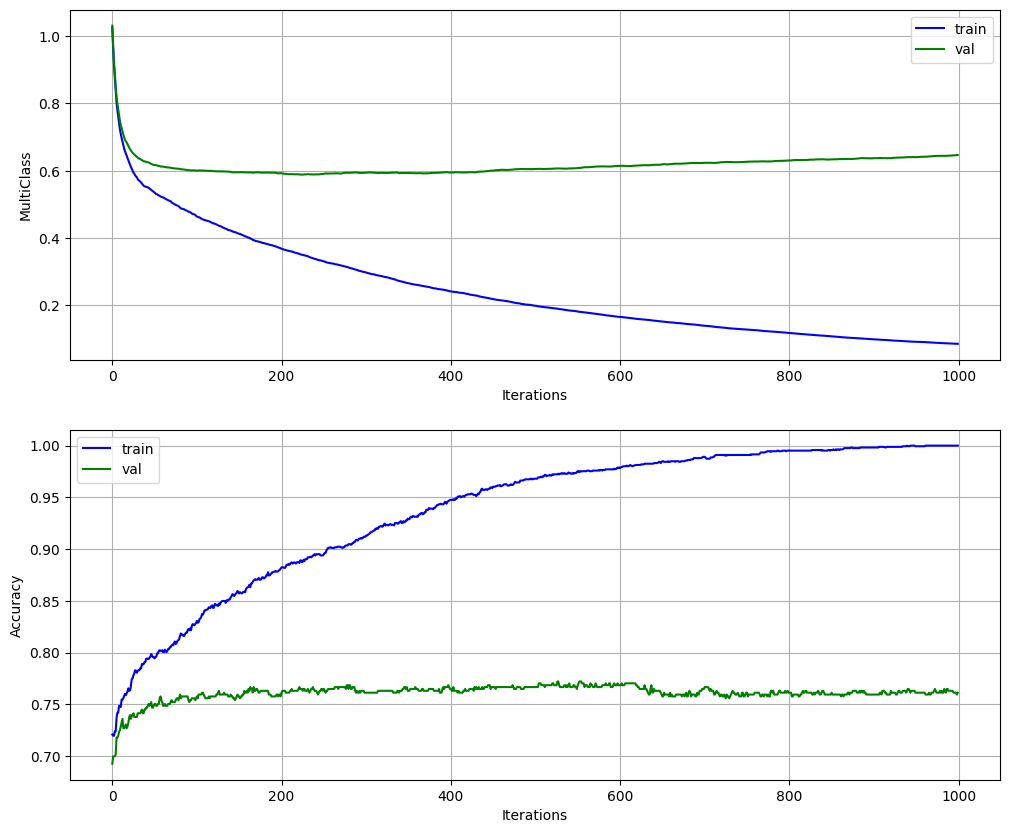

In [25]:
# Визуализируйте изменение ошибки и accuracy в процессе обучения catb_stud_def

catb_stud_def_evals_result = catb_stud_def.get_evals_result()

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(catb_stud_def_evals_result['learn']['MultiClass'], label='train', color='blue')
ax[0].plot(catb_stud_def_evals_result['validation']['MultiClass'], label='val', color='green')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('MultiClass')
ax[0].legend()
ax[0].grid()

ax[1].plot(catb_stud_def_evals_result['learn']['Accuracy'], label='train', color='blue')
ax[1].plot(catb_stud_def_evals_result['validation']['Accuracy'], label='val', color='green')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid()

plt.legend()
plt.show()

In [26]:
# Постройте отчёт по метрикам классификации для модели catb_stud_def на тестовой выборке

print(classification_report(y_stud_test, catb_stud_def.predict(X_stud_test), digits=4))

              precision    recall  f1-score   support

     Dropout     0.8043    0.7342    0.7676       711
    Enrolled     0.4968    0.3955    0.4404       397
    Graduate     0.7995    0.9031    0.8481      1104

    accuracy                         0.7577      2212
   macro avg     0.7002    0.6776    0.6854      2212
weighted avg     0.7467    0.7577    0.7491      2212



In [27]:
# Обучите модель catb_stud_es c ранней остановкой после 50 итераций
# Для обучения и валидации используйте sample_train и sample_val

catb_stud_es_params = {
    'cat_features': stud_cat_feat,
    'eval_metric': 'Accuracy',
    'random_state': RANDOM_STATE,
    'verbose': False
}

catb_stud_es = CatBoostClassifier(**catb_stud_es_params).fit(
    X_stud_sample_train, y_stud_sample_train, 
    eval_set=(X_stud_sample_val, y_stud_sample_val),
    early_stopping_rounds=50
)

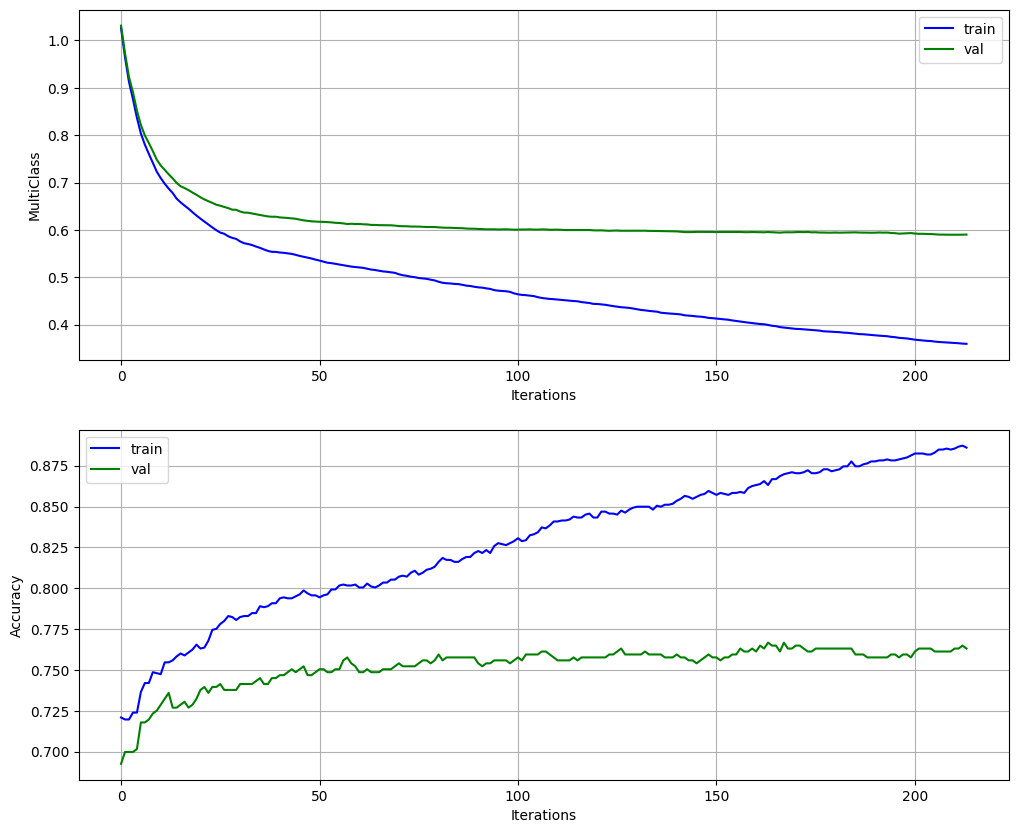

In [32]:
# Визуализируйте изменение ошибки и accuracy в процессе обучения catb_stud_es

catb_stud_es_evals_result = catb_stud_es.get_evals_result()

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(catb_stud_es_evals_result['learn']['MultiClass'], label='train', color='blue')
ax[0].plot(catb_stud_es_evals_result['validation']['MultiClass'], label='val', color='green')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('MultiClass')
ax[0].legend()
ax[0].grid()

ax[1].plot(catb_stud_es_evals_result['learn']['Accuracy'], label='train', color='blue')
ax[1].plot(catb_stud_es_evals_result['validation']['Accuracy'], label='val', color='green')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid()

plt.show()

In [33]:
# Постройте отчёт по метрикам классификации для модели catb_stud_es на тестовой выборке

print(classification_report(y_stud_test, catb_stud_es.predict(X_stud_test), digits=4))

              precision    recall  f1-score   support

     Dropout     0.8055    0.7398    0.7713       711
    Enrolled     0.5018    0.3526    0.4142       397
    Graduate     0.7914    0.9176    0.8498      1104

    accuracy                         0.7590      2212
   macro avg     0.6996    0.6700    0.6784      2212
weighted avg     0.7440    0.7590    0.7464      2212



In [42]:
# Определите целевую функцию objective для оптимизации параметров с помощью optuna
# Не забудьте фиксировать random_state, где это возможно

def objective(trial, X, y, cat_features, cv=4, random_state=None):
    """
    Целевая функция для оптимизации гиперпараметров CatBoostClassifier с помощью optuna.

    Аргументы:
        trial (optuna.trial.Trial): Объект trial для предложения гиперпараметров.
        X (pandas.DataFrame): Таблица с признаками.
        y (array-like): Массив значений целевой переменной.
        cat_features (list[str]): Список с категориальными признаками.
        cv (int): Количество фолдов для стратифицированной кросс-валидации. По умолчанию — 5.
        random_state : (int|None): Сид для фиксирования случайного состояния. По умолчанию — None (не фиксировать).
    """
    params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.05, 1, log=True), # Темп обучения: float между 0.05 и 1 в логарифмическом масштабе    
    'max_depth': trial.suggest_int('max_depth', 1, 8), # Максимальная глубина деревьев: int между 1 и 8
    'n_estimators': trial.suggest_int('n_estimators', 100, 800), # Количество деревьев в ансамбле: int между 100 и 800
    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0), # Доля признаков, используемых для построения каждого уровня дерева: float между 0.05 и 1.0

    'cat_features': cat_features,
    'eval_metric': 'Accuracy',
    'random_state': random_state, 
    'verbose': False
    }

    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 20, 100) # Критерий остановки: int между 20 и 100
    
    accuracy_scores = []

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]    
        model = CatBoostClassifier(**params).fit(X_train, y_train, eval_set=(X_val, y_val), 
                                         early_stopping_rounds=early_stopping_rounds)
        accuracy_scores.append(model.best_score_.get('validation', {}).get('Accuracy', 0)) # val
    
    return np.mean(accuracy_scores)

In [43]:
# Оптимизируйте гиперпараметры модели с помощью optuna (sampler — TPESampler)
# Для подбора гиперпараметров используйте train
# Не забудьте зафиксировать RANDOM_STATE (в seed TPESampler)

n_trials = 60 # Количество тестируемых комбинаций параметров
cv = 4 # Количество фолдов при кросс-валидации

stud_sampler = TPESampler(seed=RANDOM_STATE)

stud_study = optuna.create_study(
    direction='maximize', # Максимизация accuracy
    sampler=stud_sampler,
    study_name='CatBoostClassifier'
)

stud_study.optimize(lambda trial: objective(trial, X_stud_train, y_stud_train, cat_features=stud_cat_feat, cv=cv, random_state=RANDOM_STATE), 
    n_trials=n_trials)

[I 2025-10-31 15:06:27,543] A new study created in memory with name: CatBoostClassifier
[I 2025-10-31 15:06:47,328] Trial 0 finished with value: 0.7735081374321882 and parameters: {'learning_rate': 0.15355286838886856, 'max_depth': 8, 'n_estimators': 613, 'colsample_bylevel': 0.6187255599871848, 'early_stopping_rounds': 32}. Best is trial 0 with value: 0.7735081374321882.
[I 2025-10-31 15:06:54,333] Trial 1 finished with value: 0.7613019891500904 and parameters: {'learning_rate': 0.07978542347074176, 'max_depth': 1, 'n_estimators': 707, 'colsample_bylevel': 0.6210592611560484, 'early_stopping_rounds': 77}. Best is trial 0 with value: 0.7735081374321882.
[I 2025-10-31 15:07:12,333] Trial 2 finished with value: 0.767631103074141 and parameters: {'learning_rate': 0.05318033256270143, 'max_depth': 8, 'n_estimators': 683, 'colsample_bylevel': 0.25172215514436236, 'early_stopping_rounds': 34}. Best is trial 0 with value: 0.7735081374321882.
[I 2025-10-31 15:07:19,702] Trial 3 finished with v

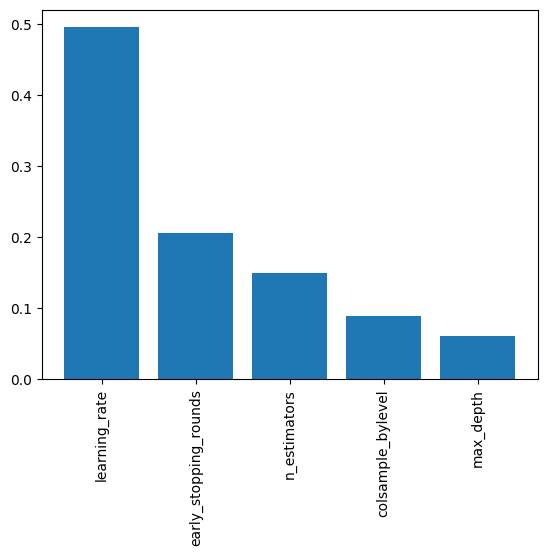

In [49]:
# Визуализируйте важность гиперпараметров обучения после оптимизации

param_importance = get_param_importances(stud_study)

plt.bar(param_importance.keys(), param_importance.values())
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Выведете оптимальные гиперпараметры

stud_study.best_params

{'learning_rate': 0.22761299648310693,
 'max_depth': 7,
 'n_estimators': 227,
 'colsample_bylevel': 0.23063489135175444,
 'early_stopping_rounds': 69}

In [52]:
# Обучите модель catb_stud c оптимальными гиперпараметрами
# Для обучения и валидации используйте sample_train и sample_val

catb_stud_params = {
    'cat_features': stud_cat_feat,
    'eval_metric': 'Accuracy',
    'random_state': RANDOM_STATE,
    'verbose': False
}

catb_stud = CatBoostClassifier(**catb_stud_params,
                               learning_rate=0.22761299648310693,
                               max_depth=7,
                               n_estimators=227,
                               colsample_bylevel=0.23063489135175444).fit(
            X_stud_sample_train, y_stud_sample_train, 
            eval_set=(X_stud_sample_val, y_stud_sample_val),
            early_stopping_rounds=69)

In [53]:
# Постройте отчёт по метрикам классификации для модели catb_stud на тестовой выборке

print(classification_report(y_stud_test, catb_stud.predict(X_stud_test), digits=4))

              precision    recall  f1-score   support

     Dropout     0.8033    0.7525    0.7771       711
    Enrolled     0.5263    0.3778    0.4399       397
    Graduate     0.8017    0.9158    0.8550      1104

    accuracy                         0.7667      2212
   macro avg     0.7105    0.6820    0.6906      2212
weighted avg     0.7528    0.7667    0.7554      2212



In [54]:
# Определите наиболее влиятельный признак в модели catb_stud

stud_importance = pd.DataFrame({
    'feat_name': catb_stud.feature_names_,
    'feat_importance': catb_stud.get_feature_importance(),
})

stud_importance.sort_values(by=['feat_importance'], ascending=False)

,feat_name,feat_importance
27,Curricular units 2nd sem (approved),14.966723
21,Curricular units 1st sem (approved),10.848113
28,Curricular units 2nd sem (grade),6.882904
26,Curricular units 2nd sem (evaluations),6.427874
22,Curricular units 1st sem (grade),5.947090
3,Course,5.409044
1,Application mode,5.351013
7,Mother's qualification,4.691456
25,Curricular units 2nd sem (enrolled),4.494522
13,Tuition fees up to date,4.429446
